# Importation des modules

In [15]:
import nilmtk
import nilmtk.utils
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import copy
import warnings
import seaborn as sns

from os.path import join
from __future__ import print_function, division
from six import iteritems
from matplotlib import rcParams
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
from nilmtk.utils import print_dict,find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.disaggregate import Disaggregator
from nilmtk.electric import get_vampire_power
from nilmtk.metrics import f1_score
from warnings import warn

%matplotlib inline

In [16]:
rcParams['figure.figsize'] = (13, 6)

# Importation des données

In [17]:
# Data file directory
data_dir = r'C:\Users\steph\Documents\Data\low_freq'

# Make the Data set
Data = DataSet(join(data_dir, 'REDD.h5'))
train = DataSet(join(data_dir, 'REDD.h5'))
test = DataSet(join(data_dir, 'REDD.h5')) 

# Visualisation des données 

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


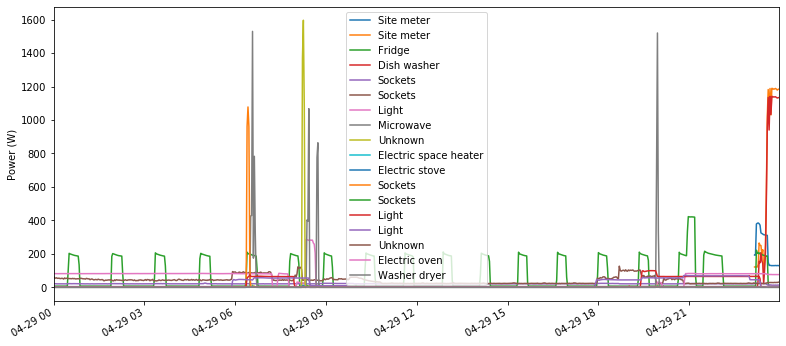

In [36]:
train.set_window(start="2011-04-29", end="2011-04-30")
#test.set_window(start="2011-04-30")

data1 = train.buildings[1].elec
data1.plot()

In [37]:
data1.appliances

[Appliance(type='fridge', instance=1),
 Appliance(type='electric oven', instance=1),
 Appliance(type='light', instance=2),
 Appliance(type='sockets', instance=3),
 Appliance(type='sockets', instance=4),
 Appliance(type='light', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='light', instance=3),
 Appliance(type='unknown', instance=2),
 Appliance(type='microwave', instance=1),
 Appliance(type='electric stove', instance=1),
 Appliance(type='unknown', instance=1),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='electric space heater', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='sockets', instance=2)]

# Définition des fonctions 

In [20]:
# This function allows to create the trainset, to choose the appliances and to exclude buildings
def get_all_trainings(appliance, dataset, buildings_to_exclude):

    # Filtering by appliances: 
    elecs = []
    for app in appliance:
        app_l = [app]
        print ('Now loading data for ' + app + ' for all buildings in the data to create the metergroup')
        print()
        for building in dataset.buildings: 
            if building not in buildings_to_exclude:
                print ('Processing Building ' + str(building) + '...')
                print()
                try:
                    elec = dataset.buildings[building].elec[app]       
                    
                    elecs.append(elec)

                except KeyError:
                    print ('Appliance '+str(app)+' does not exist in this building')
                    print ('Building skipped...')
                    print ()
            

    metergroup = MeterGroup(elecs)

    return metergroup

In [21]:
#This function allows to make prediction with the trained model and test dataset
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    return gt,pred

In [22]:
#This function allows to calculate true positives,false positives,true negative and false negatives 
def tp_fp_fn_tn (predicted_states, ground_truth_states):
    predicted_states_on = predicted_states > 0
    ground_truth_states_on = ground_truth_states > 0
    tp = np.sum(np.logical_and(predicted_states_on.values == True,ground_truth_states_on.values == True), axis=0)
    fp = np.sum(np.logical_and(predicted_states_on.values == True,
                ground_truth_states_on.values == False), axis=0)
    fn = np.sum(np.logical_and(predicted_states_on.values == False,
                ground_truth_states_on.values == True), axis=0)
    tn = np.sum(np.logical_and(predicted_states_on.values == False,
                ground_truth_states_on.values == False), axis=0)
    return np.array ([tp, fp, fn, tn]).astype(float)

In [23]:
#This function allows to calculate precision, accuracy, f1-score and recall
def precision_recall_acc_f1 (predicted_states, ground_truth_states):
    
    predicted_states_on = predicted_states > 0
    ground_truth_states_on = ground_truth_states > 0
    P = np.sum(ground_truth_states_on==True)
    N = np.sum(ground_truth_states_on==False)
    
    tfpn = tp_fp_fn_tn (predicted_states, ground_truth_states)
    prec = tfpn[0, :] / (tfpn[0, :] + tfpn[1, :])
    rec = tfpn[0, :] / (tfpn[0, :] + tfpn[2, :])
    f1= 2*prec*rec/(prec+rec)
    acc= (tfpn[0, :]+tfpn[3, :])/(P+N)
    
   
    return np.array ([acc,f1,prec,rec])

# Création des ensembles d'entraînement et de test

In [26]:
try:
    data_dir  = r'C:\Users\steph\Documents\Data\low_freq'
    building_number = all
    data = DataSet(join(data_dir, 'redd.h5'))
    print("Loading building " + str(building_number))


    applianceName = ['fridge','sockets','microwave' ]
    buildings_to_exclude = [4,5]

    elec=get_all_trainings(applianceName, data, buildings_to_exclude)
    test_elec=data.buildings[5].elec
 

    top_train_elec = elec

except:
    print('ValueError: end date must be after start date')


Loading building <built-in function all>
Now loading data for fridge for all buildings in the data to create the metergroup

Processing Building 1...

Processing Building 2...

Processing Building 3...

Processing Building 6...

Now loading data for sockets for all buildings in the data to create the metergroup

Processing Building 1...

Processing Building 2...

Processing Building 3...

Processing Building 6...

Now loading data for microwave for all buildings in the data to create the metergroup

Processing Building 1...

Processing Building 2...

Processing Building 3...

Processing Building 6...

Appliance microwave does not exist in this building
Building skipped...



# Entraînement du modèle

In [38]:
classifiers = {'CO':CombinatorialOptimisation()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    
    
    
    
    clf.train(top_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, data.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=6, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'


C:\Users\steph\anaconda3+\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=3, building=6, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'


C:\Users\steph\anaconda3+\envs\nilmtk-env\lib\site-packages\nilmtk\feature_detectors\cluster.py:70: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  k_means.fit(X)


Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'


C:\Users\steph\anaconda3+\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'


C:\Users\steph\anaconda3+\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Training model for submeter 'ElecMeter(instance=16, building=3, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'


C:\Users\steph\anaconda3+\envs\nilmtk-env\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done training!
Runtime = 14.84820556640625 seconds.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=6, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMe

# Traitement des données

In [39]:
# Remove index and rename columns
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()

appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels

pred_overall = pd.concat(predictions['CO'])
pred_overall.index = pred_overall.index.droplevel()
appliances_label2= [t.label() for t in pred_overall.columns.values]
pred_overall.columns= appliances_label2


#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
common_index_local = common_index_utc.tz_convert(train.metadata['timezone'])
gt_overall = gt_overall.loc[common_index_local]
pred_overall = pred_overall.loc[common_index_local]

#Standardisation 

#pred_overall_std=(pred_overall-pred_overall.min())/(pred_overall.max()-pred_overall.min())
#gt_overall_std=(gt_overall-gt_overall.min())/(gt_overall.max()-gt_overall.min())
pred_overall_std=(pred_overall - pred_overall.mean()) / pred_overall.std(ddof = 0)    
gt_overall_std=(gt_overall - gt_overall.mean()) / gt_overall.std(ddof = 0)



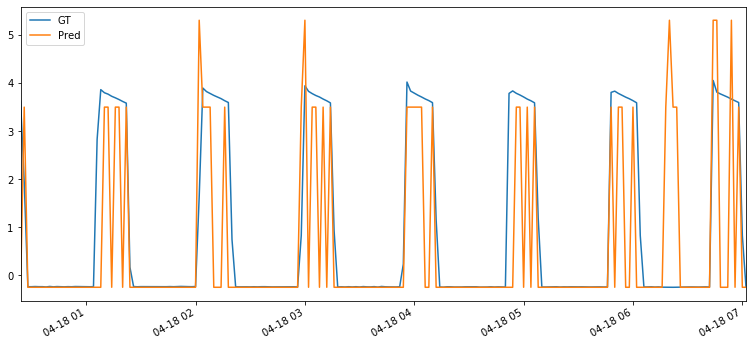

In [40]:
gt_overall_std['Fridge'].head(200).plot(label="GT")
pred_overall_std.iloc[:,3].head(200).plot(label="Pred")
pred_df=pd.DataFrame(pred_overall_std.iloc[:,3])
plt.legend()

# Evaluation du modèle

No handles with labels found to put in legend.


[[ 1457.]
 [  474.]
 [  532.]
 [29096.]]
[[0.9681231978199563], [0.7433673469387754], [0.7545313309166235], [0.7325289089994972]]


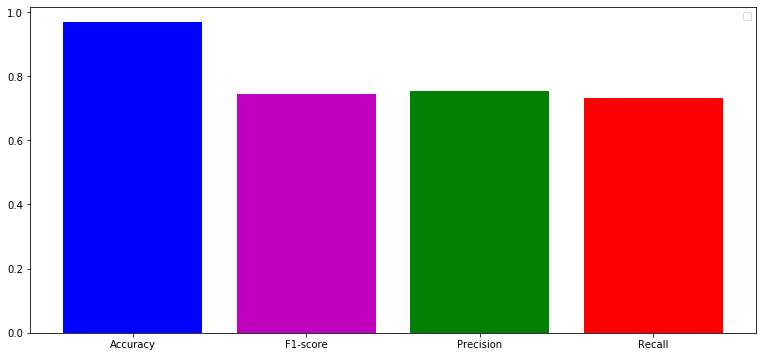

In [41]:
result = tp_fp_fn_tn (pred_df,gt_overall_std[['Fridge']])
print(result)

Eval=precision_recall_acc_f1 (pred_df,gt_overall_std[['Fridge']])
print(Eval.tolist())

# Plot Eval

x=['Accuracy','F1-score','Precision','Recall']

y=[Eval.tolist()[0][0],Eval.tolist()[1][0],Eval.tolist()[2][0],Eval.tolist()[3][0]]


plt.bar(x,y,color=('b','m','g','r'))
plt.legend()


Interpretation 

-Accuracy is the number of correctly predicted data points out of all the data points.
A true positive or true negative is a data point that the algorithm correctly classified as true or false, respectively.

-La précision compte la proportion d'items pertinents parmi les items sélectionnés alors que le rappel compte la proportion d'items pertinents sélectionnés parmi tous les items pertinents sélectionnables.


